In [4]:
import requests
from datetime import datetime
import math
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from ipywidgets import interact, IntSlider

# Retrieve RDI data from FRED API
api_key = "b613f51921dab64aeae0bb2fe2894ea7"
series_id = "A229RX0"
today = datetime.today().strftime('%Y-%m-%d')
url = f"https://api.stlouisfed.org/fred/series/observations?series_id={series_id}&api_key={api_key}&file_type=json&observation_start=1960-01-01&observation_end={today}&frequency=a"

# Send a request to the FRED API and get the JSON response
response = requests.get(url)
data = response.json()["observations"]

ModuleNotFoundError: No module named 'pandas'

In [3]:
# Define the presidents' names dictionary with start and end years
presidents = {
    (1960, 1964): 'Lyndon B. Johnson - 1st term',
    (1964, 1968): 'Lyndon B. Johnson - 2nd term',
    (1968, 1972): 'Richard Nixon',
    (1972, 1976): 'Gerald Ford',
    (1976, 1980): 'Jimmy Carter',
    (1980, 1984): 'Ronald Reagan - 1st term',
    (1984, 1988): 'Ronald Reagan - 2nd term',
    (1988, 1992): 'George H.W. Bush',
    (1992, 1996): 'Bill Clinton - 1st term',
    (1996, 2000): 'Bill Clinton - 2nd term',
    (2000, 2004): 'George W. Bush - 1st term',
    (2004, 2008): 'George W. Bush - 2nd term',
    (2008, 2012): 'Barack Obama - 1st term',
    (2012, 2016): 'Barack Obama - 2nd term',
    (2016, 2020): 'Donald Trump',
    (2020, 2024): 'Joe Biden'  # Assuming Biden's term is ongoing
}

# Define a function to get the president's name for a given year
def get_president_name(year):
    year = int(year)
    for (start_year, end_year), president_name in presidents.items():
        if start_year <= year < end_year:
            return president_name
    return None

# Extract RDI data and create DataFrame
rdi_dict = {}
data_sorted = sorted(data, key=lambda x: x['date'])  # Sort data by year
for year_data in data_sorted:
    year = year_data['date'][:4]  # Extract year from date
    rdi_value = year_data['value']  # Assuming 'value' field contains RDI data
    if rdi_value is None or not rdi_value.isnumeric():
        rdi_dict[year] = None
    else:
        rdi_dict[year] = float(rdi_value)

# Create a DataFrame from the dictionary
df = pd.DataFrame.from_dict(rdi_dict, orient='index', columns=['usvalue'])
df.index.name = 'date'  # Rename the 'year' column to 'date'
# Add the 'presidents' column based on the assigned names using apply function
df['presidents'] = df.index.map(get_president_name)
df['growthvalue'] = np.log(df['usvalue'] / df['usvalue'].shift()) * 100

# Add the 'presidents' column based on the 'presidents' dictionary
#df['presidents'] = df.index.map(lambda x: presidents.get(int(x), None))

# Add the 'fecha' column with the UTC year and month encoding
df['utcyymm'] = [f"{year_data['date'][:4]}-{year_data['date'][5:7]}" for year_data in data_sorted]

# Rearrange the columns in the specified order
df = df[['utcyymm', 'usvalue', 'growthvalue', 'presidents']]

# Save the DataFrame as a CSV file
#file_path = "C:/Users/danbo/OneDrive - Fundacao Getulio Vargas - FGV/Info_Vote/R Code/df_data.csv"
#df.to_csv(file_path)
file_path2 = "C:/Users/danbo/OneDrive - Fundacao Getulio Vargas - FGV/Info_Vote/R Code/docs/assets/charts/df_data.csv"
df.to_csv(file_path2)

NameError: name 'data' is not defined

In [15]:
print(df)

      utcyymm  usvalue  growthvalue                    presidents
date                                                             
1960  1960-01  12654.0          NaN  Lyndon B. Johnson - 1st term
1961  1961-01  12885.0     1.809047  Lyndon B. Johnson - 1st term
1962  1962-01  13307.0     3.222637  Lyndon B. Johnson - 1st term
1963  1963-01  13611.0     2.258808  Lyndon B. Johnson - 1st term
1964  1964-01  14377.0     5.475142  Lyndon B. Johnson - 2nd term
...       ...      ...          ...                           ...
2019  2019-01  45105.0     2.876586                  Donald Trump
2020  2020-01  47729.0     5.654607                     Joe Biden
2021  2021-01  48534.0     1.672540                     Joe Biden
2022  2022-01  45345.0    -6.796467                     Joe Biden
2023  2023-01      NaN          NaN                     Joe Biden

[64 rows x 4 columns]


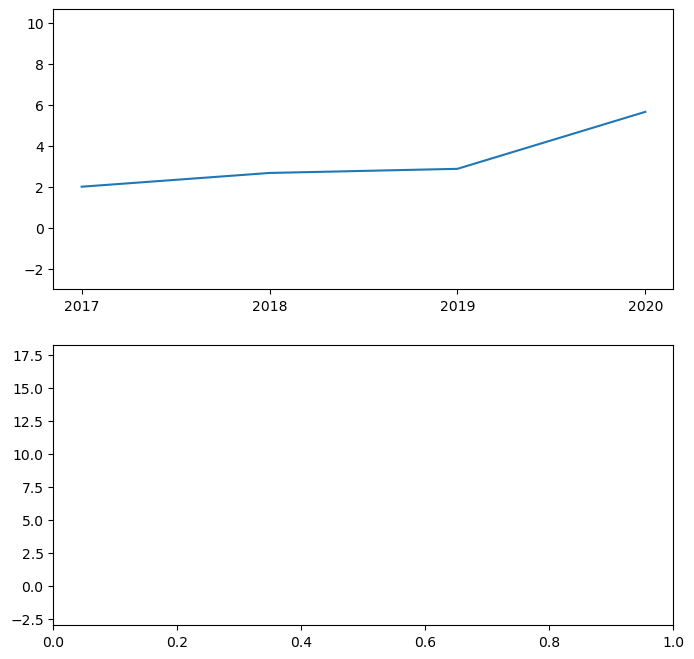

interactive(children=(IntSlider(value=2020, description='Election Year', max=2024, min=1964, step=4), Output()…

<function __main__.plot_growth(election_year)>

In [16]:
# Define a function to plot the RDI growth with a slider for election periods (For election year only)
def plot_growth(election_year):
    # Filter the data for the selected election period
    year_range = range(election_year - 3, election_year + 1)
    df_range = df.loc[df.index.isin(str(y) for y in year_range)]
    cumulative_range = df_range['growthvalue'].cumsum().sort_index()  # Change to 'growthvalue'

    # Define plot size and space
    fig, axs = plt.subplots(2, 1, figsize=(8, 8))
    axs[0].set_ylim(bottom=min(df_range['growthvalue']) - 5, top=max(df_range['growthvalue']) + 5)
    axs[1].set_ylim(bottom=min(cumulative_range) - 5, top=max(cumulative_range) + 5)

    # Plot the Yearly RDI growth for the selected period
    axs[0].plot(df_range.index, df_range['growthvalue'], label='Yearly')
    axs[0].set_title('Yearly Personal Income Growth for {}-{} ({})'.format(year_range[0], year_range[-1], presidents[election_year]), pad=20)
    axs[0].set_xlabel('Year')
    axs[0].set_ylabel('% Change in Personal Income')
    axs[0].legend()

    for x, y in zip(df_range.index, df_range['growthvalue']):
        axs[0].annotate(f'{y:.2f}', (x, y), textcoords="offset points", xytext=(0, 5), ha='center')  # Adjusted xytext to move data labels inside the plot space

    # Plot the Cumulative RDI growth for the selected period
    axs[1].plot(cumulative_range.index, cumulative_range, label='Cumulative')
    axs[1].set_title('Yearly Personal Income Growth for {}-{} ({})'.format(year_range[0], year_range[-1], presidents[election_year]), pad=20, fontsize=12)
    subtitle_text = "Each year adds the growth of all previous years, so the 4th Year shows the total growth from Years 1st-4th"
    axs[1].text(0.5, 1.01, subtitle_text, fontsize=10, ha='center', va='bottom', transform=axs[1].transAxes)
    axs[1].set_xlabel('Year')
    axs[1].set_ylabel('% Change in Personal Income')
    axs[1].legend()

    for x, y in zip(cumulative_range.index, cumulative_range):
        axs[1].annotate(f'{y:.2f}', (x, y), textcoords="offset points", xytext=(0, 5), ha='center')

    plt.tight_layout()
    plt.show()

# Create a slider for election years
election_slider = IntSlider(min=1964, max=2024, step=4, value=2020, description='Election Year')
interact(plot_growth, election_year=election_slider)